In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
import random, math, time

In [9]:
def read_img_gray(filepath):
    return Image.open(filepath).convert('L')

def histogram(image):
    L = 256  # dynamic reference (default)
    histogram = np.zeros((L))
    a = np.reshape(image, (-1))
    for pixel in a:
        histogram[pixel] = histogram[pixel] + 1
    return histogram

def cumulative_arr(arr):
    cumulative_arr = np.zeros((len(arr)))
    if len(arr) == 0:
        return cumulative_arr
    cumulative_arr[0] = arr[0]
    for i in range(1, len(arr)):
        cumulative_arr[i] = cumulative_arr[i-1] + arr[i]
    return cumulative_arr

def probabilitize(histogram):
    return histogram/np.sum(histogram)

def histogram_intensity(histogram):
    histogram_intensity = np.zeros(len(histogram))
    for i in range(len(histogram)):
        histogram_intensity[i] = histogram[i] * i
    return histogram_intensity

def get_histos(img):
    h = histogram(img)
    L = len(h)
    ph = probabilitize(h)
    cph = cumulative_arr(ph)
    phi = histogram_intensity(ph)
    cphi = cumulative_arr(phi)
    phii = histogram_intensity(phi)
    cphii = cumulative_arr(phii)
    return (h, ph, cph, phi, cphi, phii, cphii)

def segment_image(im, thresholds, h=None, ch=None, chi=None):
    L = 256
    plotting_boundaries = thresholds + [0, L - 1]
    plotting_boundaries.sort()

    h = histogram(im) if h is None else h
    ch = cumulative_arr(h) if ch is None else ch
    chi = cumulative_arr(histogram_intensity(h)) if chi is None else chi

    out = im.point(lambda x: x)
    for i in range(len(plotting_boundaries) - 1):
        t1, t2 = plotting_boundaries[i], plotting_boundaries[i + 1]
        nom = chi[t2] - chi[t1] if t1 > 0 else chi[t2]
        den = ch[t2] - ch[t1] if t1 > 0 else ch[t2]
        ui = int(nom / den) if den > 0 else (t1 + t2) // 2
        out = out.point(lambda x: ui if (t1 <= x < t2) or (x == t2 == L - 1) else x, mode='L')
    return out

def get_ssim(img_path, t):
    img = read_img_gray(img_path)
    seg = segment_image(img, t)
    ssim = structural_similarity(np.array(img), np.array(seg))
    return ssim

def get_psnr(img_path, t):
    img = read_img_gray(img_path)
    seg = segment_image(img, t)
    psnr = peak_signal_noise_ratio(np.array(img), np.array(seg))
    return psnr

EPS = 1e-6

class Otsu:
    def __init__(self, h):
        L = len(h)
        ph = probabilitize(h)
        self.__arr = -np.ones((L, L))
        self.__cph = cumulative_arr(ph)
        phi = histogram_intensity(ph)
        self.__cphi = cumulative_arr(phi)
        self.__n_T = self.__cph[-1]
        self.__u_T = self.__cphi[-1] / self.__n_T
        self.name = 'Otsu'
        self.dir = 'max'
    def get(self, st, en):
        if self.__arr[st, en]==-1:
            self.__arr[st, en] = self.calc_s(st, en)
        return self.__arr[st, en]
    def calc_s(self, st, en):
        w_i = (self.__cph[en] - self.__cph[st - 1]) if st > 0 else self.__cph[en]
        x = self.__cphi[en] - self.__cphi[st - 1] if st > 0 else self.__cphi[en]
        u_i = x / w_i if w_i != 0 else x
        sig_i = w_i * (u_i - self.__u_T) ** 2
        return sig_i

class Kapur:
    def __init__(self, h):
        L = len(h)
        ph = probabilitize(h)
        self.cph = cumulative_arr(ph)
        self.c_ph_lg = cumulative_arr(np.multiply(ph, np.log(ph, out=np.zeros_like(ph), where=(ph != 0))))
        self.arr = -np.ones((L, L))
        self.name='Kapur'
        self.dir = 'max'
    def get(self, st, en):
        if self.arr[st, en]==-1:
            self.arr[st, en] = self.entropy(st, en)
        return self.arr[st, en]
    def entropy(self, st, en):
        if en == -1:
            return -np.inf
        w_i = self.cph[en] - self.cph[st - 1] if st > 0 else self.cph[en]
        F1 = np.log(w_i, out=np.zeros_like(w_i), where=(w_i != 0))
        F2 = ((self.c_ph_lg[en] - self.c_ph_lg[st - 1]) / w_i if st > 0 else self.c_ph_lg[en] / w_i ) if w_i>0 else 0
        h_i = F1 - F2 if w_i>0 else 0
        return h_i

class Kitler:
    def __init__(self, h):
        L = len(h)
        self.__arr = np.ones((L, L)) * np.inf
        self.__h = h
        self.__ch = cumulative_arr(h)
        hi = histogram_intensity(h)
        self.__chi = cumulative_arr(hi)
        hii = histogram_intensity(hi)
        self.__chii = cumulative_arr(hii)
        self.name = 'Kittler'
        self.dir = 'min'
    def get(self, st, en):
        if self.__arr[st, en]==np.inf:
            self.__arr[st, en] = self.calc_s(st, en)
        return self.__arr[st, en]
    def calc_s(self, st, en):
        pi_ti = (self.__ch[en] - self.__ch[st - 1]) if st > 0 else self.__ch[en]
        x = self.__chi[en] - self.__chi[st - 1] if st > 0 else self.__chi[en]
        u_i = x / pi_ti if pi_ti != 0 else x
        y =  self.__chii[en] - self.__chii[st - 1] if st > 0 else self.__chii[en]
        A = y / pi_ti if pi_ti != 0 else y
        B = u_i**2
        sig2_i = A-B
        sig_i = np.sqrt(sig2_i)
        val = pi_ti * (np.log2(sig_i) - np.log2(pi_ti))
        val = 0 if math.isnan(val) or np.isneginf(val) else val
        return val

# DP_disjoint (m = 0)
def DP_disjoint(ph, ob, obkwargs, return_details=False):
    m = 0
    t_start = time.time()
    L = np.shape(ph)[0]
    o = ob(ph, **obkwargs)
    maxmin = 1 if o.dir == 'max' else -1
    scores = np.ones((L, L))
    for s in range(0, L):
        for e in range(0, L):
            scores[s, e] = o.get(s, e)
    t6 = time.time()
    mem = -np.ones((L, L)) * np.inf * maxmin
    indices = -np.ones(L)
    for i in range(0, L)[::-1]:
        for j in range(i + 1 + (m), L):
            target = - np.inf * maxmin
            picked_k = -1
            for k in range(i + 2 - (m), j + 1 - (m)):
                sc_ik = scores[i, k - 1 + (m)] if scores[i, k - 1 + (m)] > 0 else -111111 * maxmin
                if sc_ik + mem[k, j] > 0 and -maxmin * (sc_ik + mem[k, j] - target) < EPS:
                    target = sc_ik + mem[k, j]
                    picked_k = k
            sc_ij = scores[i, j] if scores[i, j] > 0 else -111111 * maxmin
            if (-maxmin * (sc_ij - target)) < EPS:
                mem[i, j] = sc_ij
                indices[i] = j
            else:
                mem[i, j] = target
                indices[i] = picked_k
    i = 0
    thresholds = []
    while i != -1:
        print(i, int(indices[i]), '\t', scores[i, int(indices[i])])
        i = int(indices[i])
        if i == L - 1:
            break
        thresholds.append(i)
    T = thresholds
    tmp = [0] + T + [L - 1]
    i = 0
    total = 0
    classes_scores = []
    while i < len(tmp) - 1:
        total += scores[tmp[i], tmp[i + 1]]
        classes_scores.append(str(scores[tmp[i], tmp[i + 1]]))
        i += 1
    if return_details:
        return thresholds, time.time() - t_start, mem, indices, scores, total, classes_scores
    else:
        return thresholds


def DP_overlapping(ph, ob, obkwargs, return_details=False):
    m = 1
    t_start = time.time()
    L = np.shape(ph)[0]
    o = ob(ph, **obkwargs)
    maxmin = 1 if o.dir == 'max' else -1
    scores = np.ones((L, L))
    for s in range(0, L):
        for e in range(0, L):
            scores[s, e] = o.get(s, e)
    t6 = time.time()
    mem = -np.ones((L, L)) * np.inf * maxmin
    indices = -np.ones(L)
    for i in range(0, L)[::-1]:
        for j in range(i + 1 + (m), L):
            target = - np.inf * maxmin
            picked_k = -1
            for k in range(i + 2 - (m), j + 1 - (m)):
                sc_ik = scores[i, k - 1 + (m)] if scores[i, k - 1 + (m)] > 0 else -111111 * maxmin
                if sc_ik + mem[k, j] > 0 and -maxmin * (sc_ik + mem[k, j] - target) < EPS:
                    target = sc_ik + mem[k, j]
                    picked_k = k
            sc_ij = scores[i, j] if scores[i, j] > 0 else -111111 * maxmin
            if (-maxmin * (sc_ij - target)) < EPS:
                mem[i, j] = sc_ij
                indices[i] = j
            else:
                mem[i, j] = target
                indices[i] = picked_k
    t6 = time.time()
    i = 0
    thresholds = []
    while i != -1:
        i = int(indices[i])
        if i == L - 1:
            break
        thresholds.append(i)
    t7 = time.time()
    T = thresholds
    tmp = [0] + T + [L - 1]
    i = 0
    total = 0
    classes_scores = []
    while i < len(tmp) - 1:
        total += scores[tmp[i], tmp[i + 1]]
        classes_scores.append(str(scores[tmp[i], tmp[i + 1]]))
        i += 1
    if return_details:
        return thresholds, t7 - t_start, mem, indices, scores, total, classes_scores
    else:
        return thresholds



def dp_n(ph, ob, obkwargs, n_thresholds, return_details=False):
    t2 = time.time()
    o = ob(ph, **obkwargs)
    maxmin = 1 if o.dir == 'max' else -1
    t55 = time.time()
    L = np.shape(ph)[0]
    dE = -np.ones((n_thresholds, L)) * np.inf * maxmin
    Pt = -1 * np.ones((n_thresholds, L), dtype=np.int32)
    scores = np.ones((L, L))
    for s in range(0, L):
        for e in range(0, L):
            scores[s, e] = o.get(s, e)
    t6 = time.time()
    for T1 in range(1, L - n_thresholds + 1):
        score = o.get(0, T1)
        dE[0, T1] = score if score > 0 else -111111 * maxmin  # TODO
    t7 = time.time()
    for k in range(2, n_thresholds + 1):
        for Tk in range(k, L - n_thresholds + k - 1 + 1):
            for Tk_1 in range(k - 1, Tk - 1 + 1):
                nobj = dE[k - 2, Tk_1 - 1] + scores[Tk_1, Tk] if scores[Tk_1, Tk] > 0 else -111111 * maxmin
                if maxmin * (nobj - dE[k - 1, Tk]) > 0:
                    dE[k - 1, Tk] = nobj
                    Pt[k - 1, Tk] = Tk_1
    t8 = time.time()
    dEM = - maxmin * np.inf
    tnstar = -1
    for tn in range(n_thresholds, L - 1 + 1):
        nobj = dE[n_thresholds - 1, tn - 1] + scores[tn, L - 1] if scores[tn, L - 1] > 0 else -111111 * maxmin
        if maxmin * (nobj - dEM) > 0:
            dEM = nobj
            tnstar = tn
    T = [tnstar]
    tkstar_new = tnstar
    for k in range(n_thresholds - 1, 1 - 1, -1):
        tkstar = tkstar_new
        tkstar_new = Pt[k, tkstar]
        T.insert(0, tkstar_new)
    t9 = time.time()
    thresholds = T
    tmp = [0] + thresholds + [L]
    i = 0
    total = 0
    classes_scores = []
    while i < len(tmp) - 1:
        total += scores[tmp[i], tmp[i + 1] - 1]
        classes_scores.append(str(scores[tmp[i], tmp[i + 1] - 1]))
        i += 1
    if return_details:
        return thresholds, t9 - t2, dE, Pt, scores, total, classes_scores
    else:
        return thresholds


C:\Users\eslam\AppData\Local\Temp\ipykernel_25488\168311950.py:143: RuntimeWarning: divide by zero encountered in log2
  val = pi_ti * (np.log2(sig_i) - np.log2(pi_ti))
C:\Users\eslam\AppData\Local\Temp\ipykernel_25488\168311950.py:143: RuntimeWarning: invalid value encountered in scalar subtract
  val = pi_ti * (np.log2(sig_i) - np.log2(pi_ti))
C:\Users\eslam\AppData\Local\Temp\ipykernel_25488\168311950.py:143: RuntimeWarning: invalid value encountered in log2
  val = pi_ti * (np.log2(sig_i) - np.log2(pi_ti))
C:\Users\eslam\AppData\Local\Temp\ipykernel_25488\168311950.py:142: RuntimeWarning: invalid value encountered in sqrt
  sig_i = np.sqrt(sig2_i)
C:\Users\eslam\AppData\Local\Temp\ipykernel_25488\168311950.py:219: RuntimeWarning: invalid value encountered in scalar subtract
  if sc_ik + mem[k, j] > 0 and -maxmin * (sc_ik + mem[k, j] - target) < EPS:
C:\Users\eslam\AppData\Local\Temp\ipykernel_25488\168311950.py:167: RuntimeWarning: invalid value encountered in scalar subtract
  if 

0 4 	 0.4035802857874821
4 6 	 0.34009358148740537
6 8 	 0.3627278368390574
8 10 	 0.3906881207230405
10 12 	 0.2726513626910565
12 18 	 0.7287530705077474


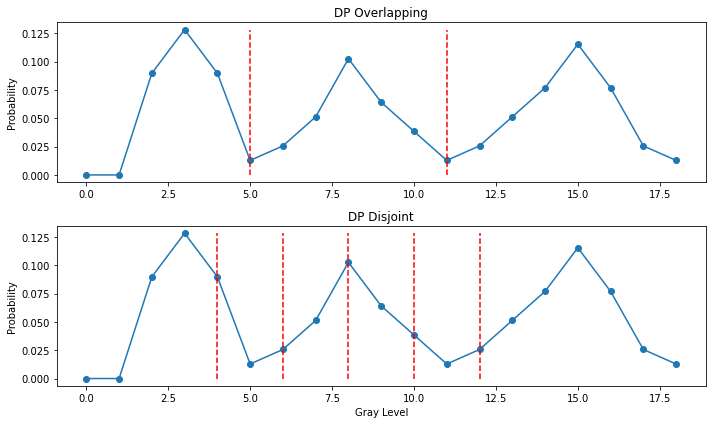

In [15]:
import matplotlib.pyplot as plt

h = [0, 0, 7, 10, 7, 1, 2, 4, 8, 5, 3, 1, 2, 4, 6, 9, 6, 2, 1]
ph = probabilitize(h)

thresholds1, runtime1, mem1, indices1, scores1, total1, classes_scores1 = DP_overlapping(
    ph, Kitler, {}, return_details=True
)
thresholds2, runtime2, mem2, indices2, scores2, total2, classes_scores2 = DP_disjoint(
    ph, Kitler, {}, return_details=True
)

plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(range(len(ph)), ph, '-o')
plt.vlines(thresholds1, ymin=0, ymax=max(ph), colors='r', linestyles='--')
plt.title('DP Overlapping')
plt.ylabel('Probability')

plt.subplot(2, 1, 2)
plt.plot(range(len(ph)), ph, '-o')
plt.vlines(thresholds2, ymin=0, ymax=max(ph), colors='r', linestyles='--')
plt.title('DP Disjoint')
plt.xlabel('Gray Level')
plt.ylabel('Probability')

plt.tight_layout()
plt.show()
